In [1]:
import sys
sys.path.append('..')
from d2l import torch as d2l
import math
import torch
from torch import nn

In [2]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        print("dim", valid_lens.dim())
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
    X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

dim 1


tensor([[[0.4539, 0.5461, 0.0000, 0.0000],
         [0.5208, 0.4792, 0.0000, 0.0000]],

        [[0.2429, 0.3234, 0.4337, 0.0000],
         [0.2779, 0.3721, 0.3500, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

dim 2


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3382, 0.4281, 0.2337, 0.0000]],

        [[0.6196, 0.3804, 0.0000, 0.0000],
         [0.2416, 0.3101, 0.2086, 0.2396]]])

In [5]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        print(queries)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[-0.8483, -1.2468,  0.6997, -0.8606, -0.5147, -1.2144, -0.4397,
           0.7697]],

        [[-0.3817, -0.6202,  0.6852, -0.6200, -1.0496,  0.3050, -0.5584,
          -0.5622]]], grad_fn=<UnsafeViewBackward>)
dim 1


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [7]:
queries, keys, values, valid_lens, attention.attention_weights

(tensor([[[ 0.2518, -2.6679, -0.2160,  1.9288,  2.0330, -1.3624,  1.1162,
            0.6174,  1.0837, -2.0783, -1.0526, -1.1000,  0.7671, -0.8373,
           -0.7792, -1.4484, -0.3422, -1.5201, -0.2180, -0.8095]],
 
         [[-1.3045,  0.2980, -2.9068,  0.9853,  2.3469, -0.3325,  0.1248,
           -0.4138, -0.2773,  0.0680,  0.6348, -0.5566,  0.9933, -0.0507,
           -0.5516, -0.1086,  1.4659, -0.3072,  0.1056, -0.4223]]]),
 tensor([[[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],
 
         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]]]),
 tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.],
          [16., 17., 18., 19.],


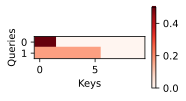

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In [9]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        d =  queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [10]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

dim 1


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

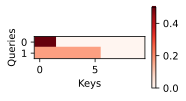

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')